# 空間アルゴリズム-spatial

このセクションでは、`scipy.spatial`モジュールで提供されるK-dツリー、凸包、ボロノイ図、ドロネー三角形分割などの空間アルゴリズムクラスの使用方法を紹介します。

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import helper.matplotlib
import helper.magics
from scipy import spatial

## 最近傍点の計算

一次元のソートされた数値に対して、二分法を使用して指定された数値に最も近い数値を迅速に見つけることができます。以下の例では、昇順にソートされたランダムな数値配列`x`で、`numpy.searchsorted()`を使用して0.5に最も近い数値を検索します。ソートアルゴリズムの時間計算量は$O(N \log N)$で、各二分探索の時間計算量は$O(\log N)$です。

In [17]:
x = np.sort(np.random.rand(100))
idx = np.searchsorted(x, 0.5)
print(x[idx], x[idx - 1])  # 0.5に最も近い数値はこの2つのうちの1つです

0.5026790232288615 0.49724850589238545


同様のアルゴリズムをN次元空間に拡張することができます。`spatial`モジュールが提供する`KDTree`クラスは、K-dツリーを使用してN次元空間内の最近傍点を迅速に検索します。以下の例では、平面上のランダムな50個の点で`KDTree`オブジェクトを作成し、`targets`内の各点に最も近い3つの点を検索します。`KDTree.query()`は2つの配列`dist`と`idx`を返します。`dist[i, :]`は`targets[i]`に最も近い3つの点の距離で、`idx[i, :]`はこれらの最近傍点のインデックスです：

In [18]:
from scipy import spatial

np.random.seed(42)
N = 100
points = np.random.uniform(-1, 1, (N, 2))
kd = spatial.KDTree(points)

targets = np.array([(0, 0), (0.5, 0.5), (-0.5, 0.5), (0.5, -0.5), (-0.5, -0.5)])
dist, idx = kd.query(targets, 3)
%C dist; idx

                 dist                        idx      
--------------------------------------  --------------
[[0.15188266, 0.21919416, 0.27647793],  [[48, 73, 81],
 [0.09595807, 0.15745334, 0.22855398],   [37, 78, 43],
 [0.05009422, 0.17583445, 0.1807312 ],   [79, 22, 92],
 [0.11180181, 0.16618122, 0.18127473],   [35, 58,  6],
 [0.19015485, 0.19060739, 0.19361173]]   [83,  7, 42]]


`KDTree.query_ball_point()`は、指定された点から一定距離以内のすべての点を検索します。これは最近傍点のインデックスのみを返します。各ターゲット点の近傍点数は必ずしも同じではないため、`idx2`配列の各要素はリストです：

In [19]:
r = 0.2
idx2 = kd.query_ball_point(targets, r)
idx2

array([list([48]), list([37, 78]), list([22, 79, 92]), list([6, 35, 58]),
       list([7, 42, 55, 83])], dtype=object)

`KDTree.query_pairs()`は、`points`内で指定された値よりも距離が小さいすべての点のペアを見つけます。これはインデックスのペアの集合オブジェクトを返します。以下のプログラムは、集合の差演算を使用して、距離が0.08から0.1の間のすべての点のペアを見つけます：

In [20]:
idx3 = kd.query_pairs(0.1) - kd.query_pairs(0.08)
%col 6 idx3

{(1, 46),     (3, 21),     (3, 82),     (3, 95),     (5, 16),     (9, 30),    
 (10, 87),    (11, 42),    (11, 97),    (18, 41),    (29, 74),    (32, 51),   
 (37, 78),    (39, 61),    (41, 61),    (50, 84),    (55, 83),    (73, 81)}   


次のグラフでは、`target`内の各点（五角星で表示）に最も近い点が同じ色で識別されています：

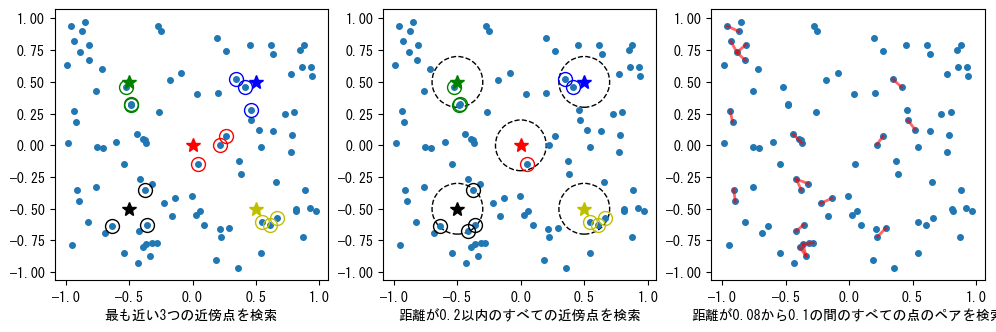

In [21]:
x, y = points.T
colors = "r", "b", "g", "y", "k"

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

for ax in ax1, ax2, ax3:
    ax.set_aspect("equal")
    ax.plot(x, y, "o", markersize=4)

for ax in ax1, ax2:
    for i in range(len(targets)):
        c = colors[i]
        tx, ty = targets[i]
        ax.plot([tx], [ty], "*", markersize=10, color=c)

for i in range(len(targets)):
    nx, ny = points[idx[i]].T
    ax1.plot(
        nx,
        ny,
        "o",
        markersize=10,
        markerfacecolor="None",
        markeredgecolor=colors[i],
        markeredgewidth=1,
    )

    nx, ny = points[idx2[i]].T
    ax2.plot(
        nx,
        ny,
        "o",
        markersize=10,
        markerfacecolor="None",
        markeredgecolor=colors[i],
        markeredgewidth=1,
    )

    ax2.add_artist(plt.Circle(targets[i], r, fill=None, linestyle="dashed"))

for pidx1, pidx2 in idx3:
    sx, sy = points[pidx1]
    ex, ey = points[pidx2]
    ax3.plot([sx, ex], [sy, ey], "r", linewidth=2, alpha=0.6)

ax1.set_xlabel("最も近い3つの近傍点を検索")
ax2.set_xlabel("距離が0.2以内のすべての近傍点を検索")
ax3.set_xlabel("距離が0.08から0.1の間のすべての点のペアを検索");

`KDTree`のすべての検索メソッドには、2点間の距離を計算する関数を定義するためのパラメータ`p`があります。異なる`p`パラメータを使用して、上のグラフの変化を観察してみてください：

* `p = 1`：絶対値の合計を距離とする
* `p = 2`：ユークリッド距離
* `p = np.inf`：最大座標差を距離とする

さらに、`KDTree.query_ball_tree()`は、2つのK-dツリー間で指定された値よりも距離が小さいすべての点のペアを検索できます。

`distance`サブモジュールの`pdist()`は、点の集合内の各点のペアの距離を計算します。`cdist()`は、2つの点の集合内の各点のペアの距離を計算します。`pdist()`が返すのは圧縮された1次元配列であるため、`squareform()`を使用して2次元配列に変換する必要があります。`dist[i, j]`は、`points`内のインデックス`i`と`j`の2点の距離です。`dist2[i, j]`は、`points[i]`と`targets[j]`の間の距離です。

In [22]:
from scipy.spatial import distance

dist1 = distance.squareform(distance.pdist(points))
dist2 = distance.cdist(points, targets)
%C dist1.shape; dist2.shape

dist1.shape  dist2.shape
-----------  -----------
(100, 100)   (100, 5)   


以下は、`np.min()`を使用して`dist2`内で`points`内の`targets`に最も近い点を検索する例です。結果は`KDTree.query()`の結果と同じです：

In [23]:
print(dist[:, 0])  # KDTree.query()が返すtargetsに最も近い距離
print(np.min(dist2, axis=0))

[0.15188266 0.09595807 0.05009422 0.11180181 0.19015485]
[0.15188266 0.09595807 0.05009422 0.11180181 0.19015485]


`points`内の最も近い点のペアを見つけるには、`dist1`の対角線上の要素を無限大に設定する必要があります：

In [24]:
dist1[np.diag_indices(len(points))] = np.inf
nearest_pair = np.unravel_index(np.argmin(dist1), dist1.shape)
print(nearest_pair, dist1[nearest_pair])

(np.int64(22), np.int64(92)) 0.005346210248158245


`KDTree.query()`を使用して、この最も近い点のペアを迅速に見つけることができます：K-dツリー内でそれ自体が含む点を検索し、各点に最も近い2つの点を見つけます。最も近い点はそれ自体で、距離は0です。次に近い点が各点の最近傍点であり、これらの距離の中で最小のものを見つけるだけです：

In [25]:
dist, idx = kd.query(points, 2)
print(idx[np.argmin(dist[:, 1])], np.min(dist[:, 1]))

[22 92] 0.005346210248158245


## 凸包

凸包とは、N次元空間内の領域で、その領域内の任意の2点間の線分が完全にその領域内に含まれるものです。2次元平面上の凸多角形は典型的な凸包です。`ConvexHull`は、N次元空間内の点の集合を含む最小の凸包を迅速に計算できます。まず2次元の例を見てみましょう：`points2d`は2次元平面上のランダムな点の集合で、`ch2d`はこれらの点の凸包オブジェクトです。`ConvexHull.simplices`は凸包の各辺の2つの頂点の`points2d`内のインデックスで、その形状が`(5, 2)`であるため、凸包は5つの線分で構成されます。2次元の場合、`ConvexHull.vertices`は凸多角形の各頂点の`points2d`内のインデックスで、反時計回りの順序で並んでいます。

In [26]:
np.random.seed(42)
points2d = np.random.rand(10, 2)
ch2d = spatial.ConvexHull(points2d)
%C ch2d.simplices; ch2d.vertices

ch2d.simplices   ch2d.vertices 
--------------  ---------------
[[2, 5],        [5, 2, 6, 1, 0]
 [2, 6],                       
 [0, 5],                       
 [1, 6],                       
 [1, 0]]                       


`matplotlib`の`Polygon`オブジェクトを使用して、次のグラフに示す多角形を描画できます：

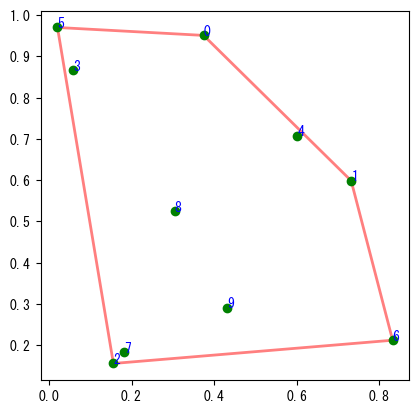

In [27]:
poly = plt.Polygon(points2d[ch2d.vertices], fill=None, lw=2, color="r", alpha=0.5)
ax = plt.subplot(aspect="equal")
plt.plot(points2d[:, 0], points2d[:, 1], "go")
for i, pos in enumerate(points2d):
    plt.text(pos[0], pos[1], str(i), color="blue")
ax.add_artist(poly);

3次元空間内の凸包は凸多面体で、各面は三角形です。以下の例では、`simplices`の形状から、得られた凸包は38個の三角形面で構成されていることがわかります：

In [28]:
np.random.seed(42)
points3d = np.random.rand(40, 3)
ch3d = spatial.ConvexHull(points3d)
ch3d.simplices.shape

(38, 3)

以下のプログラムは、PyVistaを使用して凸包を視覚的に表示します。図中のすべての緑色の球は`points3d`内の点を表し、赤色の線分で構成される三角形面は凸多面体の面を表します。赤色の線分に接続されていない点は凸包内の点です：

In [29]:
import pyvista as pv
from helper.pyvista import plotter_to_iframe

hull = pv.PolyData.from_regular_faces(ch3d.points, faces=ch3d.simplices)
points = pv.PolyData(points3d)
sphere = pv.Sphere(radius=0.02, theta_resolution=6, phi_resolution=6)
glyphs = points.glyph(orient=False, scale=False, geom=sphere)
plot = pv.Plotter()
plot.add_mesh(glyphs, color="green")
plot.add_mesh(hull, opacity=0.75, line_width=2, edge_color="red", show_edges=True)
plotter_to_iframe(plot)

<iframe srcdoc="<!DOCTYPE html>
<html>
 <head>
 <meta http-equiv="Content-type" content="text/html; charset=utf-8"/>
 <meta name="viewport" content="width=device-width, height=device-height, initial-scale=1, maximum-scale=1, minimum-scale=1, user-scalable=no">
 </head>
 <body>
 <div class="content"></div>
<script type="text/javascript">
!function(){var e={334:function(){const e=document.querySelector("head");e&&[16,32,96,160,196].forEach((t=>{const n=document.createElement("link");n.setAttribute("rel","icon"),n.setAttribute("href",`https://kitware.github.io/vtk-js/icon/favicon-${t}x${t}.png`),n.setAttribute("sizes",`${t}x${t}`),n.setAttribute("type","image/png"),e.appendChild(n)}))},819:function(e,t,n){"use strict";n.r(t),n.d(t,{initLocalFileLoader:function(){return cI},load:function(){return lI}});var r={};n.r(r),n.d(r,{add:function(){return Q},adjoint:function(){return v},clone:function(){return u},copy:function(){return d},create:function(){return c},determinant:function(){return y},equals:function(){return re},exactEquals:function(){return ne},frob:function(){return Z},fromQuat:function(){return k},fromQuat2:function(){return V},fromRotation:function(){return O},fromRotationTranslation:function(){return D},fromRotationTranslationScale:function(){return _},fromRotationTranslationScaleOrigin:function(){return F},fromScaling:function(){return P},fromTranslation:function(){return w},fromValues:function(){return p},fromXRotation:function(){return R},fromYRotation:function(){return M},fromZRotation:function(){return E},frustum:function(){return G},getRotation:function(){return N},getScaling:function(){return B},getTranslation:function(){return L},identity:function(){return g},invert:function(){return h},lookAt:function(){return q},mul:function(){return oe},multiply:function(){return T},multiplyScalar:function(){return ee},multiplyScalarAndAdd:function(){return te},ortho:function(){return K},orthoNO:function(){return j},orthoZO:function(){return $},perspective:function(){return z},perspectiveFromFieldOfView:function(){return H},perspectiveNO:function(){return U},perspectiveZO:function(){return W},rotate:function(){return C},rotateX:function(){return S},rotateY:function(){return A},rotateZ:function(){return I},scale:function(){return x},set:function(){return f},str:function(){return Y},sub:function(){return ae},subtract:function(){return J},targetTo:function(){return X},translate:function(){return b},transpose:function(){return m}});var o={};n.r(o),n.d(o,{add:function(){return Me},adjoint:function(){return me},clone:function(){return le},copy:function(){return ce},create:function(){return ie},determinant:function(){return he},equals:function(){return Be},exactEquals:function(){return Le},frob:function(){return Re},fromMat2d:function(){return Ae},fromMat4:function(){return se},fromQuat:function(){return Ie},fromRotation:function(){return Ce},fromScaling:function(){return Se},fromTranslation:function(){return xe},fromValues:function(){return ue},identity:function(){return pe},invert:function(){return ge},mul:function(){return Ne},multiply:function(){return ve},multiplyScalar:function(){return De},multiplyScalarAndAdd:function(){return Ve},normalFromMat4:function(){return we},projection:function(){return Pe},rotate:function(){return Te},scale:function(){return be},set:function(){return de},str:function(){return Oe},sub:function(){return _e},subtract:function(){return Ee},translate:function(){return ye},transpose:function(){return fe}}),n(334);var a=1e-6,i="undefined"!=typeof Float32Array?Float32Array:Array;Math.random;var s=Math.PI/180;function l(e){return e*s}function c(){var e=new i(16);return i!=Float32Array&&(e[1]=0,e[2]=0,e[3]=0,e[4]=0,e[6]=0,e[7]=0,e[8]=0,e[9]=0,e[11]=0,e[12]=0,e[13]=0,e[14]=0),e[0]=1,e[5]=1,e[10]=1,e[15]=1,e}function u(e){var t=new i(16);return t[0]=e[0],t[1]=e[1],t[2]=e[2],t[3]=e[3],t[4]=e[4],t[5]=e[5],t[6]=e[6],t[7]=e[7],t[8]=e[8],t[9]=e[9],t[10]=e[10],t[11]=e[11],t[12]=e[12],t[13]=e[13],t[14]=e[14],t[15]=e[

## ボロノイ図

ボロノイ図（Voronoi Diagram）は、空間を指定されたN個の母点に基づいてN個の領域に分割する空間分割アルゴリズムです。各領域内のすべての座標点は、その領域に対応する母点に最も近いです。

In [30]:
points2d = np.array(
    [
        [0.2, 0.1],
        [0.5, 0.5],
        [0.8, 0.1],
        [0.5, 0.8],
        [0.3, 0.6],
        [0.7, 0.6],
        [0.5, 0.35],
    ]
)
vo = spatial.Voronoi(points2d)

%C vo.vertices; vo.regions; vo.ridge_vertices

   vo.vertices          vo.regions     vo.ridge_vertices
------------------  -----------------  -----------------
[[0.5   , 0.045 ],  [[-1, 0, 1],       [[-1, 0],        
 [0.245 , 0.351 ],   [-1, 0, 2],        [0, 1],         
 [0.755 , 0.351 ],   [],                [-1, 1],        
 [0.3375, 0.425 ],   [6, 4, 3, 5],      [0, 2],         
 [0.6625, 0.425 ],   [5, -1, 1, 3],     [-1, 2],        
 [0.45  , 0.65  ],   [4, 2, 0, 1, 3],   [3, 5],         
 [0.55  , 0.65  ]]   [6, -1, 2, 4],     [3, 4],         
                     [6, -1, 5]]        [4, 6],         
                                        [5, 6],         
                                        [1, 3],         
                                        [-1, 5],        
                                        [2, 4],         
                                        [-1, 6]]        


`voronoi_plot_2d()`を使用すると、ボロノイ図を図として表示できます。その効果は次のグラフ（左）に示されています。図中の青い小さな円点は`points2d`で指定された母点で、赤い大きな円点は`Voronoi.vertices`の点を表しています。図中では各`vertices`点に添字が付けられています。点線と実線によって空間が7つの領域に分割されており、点線で囲まれた領域は無限に広がる領域で、すべて実線で囲まれた領域は有限の領域です。各領域は`vertices`の点を頂点としています。

`Voronoi.regions`は領域のリストで、各領域はリスト（空リストは無視）で表されます。リスト内の整数は`vertices`のインデックスで、-1を含む領域は無限領域です。例えば`[6, 4, 3, 5]`は図の中央にある領域です。

`Voronoi.ridge_vertices`は領域の分割線のリストで、各分割線は`vertices`の2つのインデックスで構成されます。-1を含む分割線は図中の点線で、その長さは無限です。

各領域を異なる色で塗りつぶしたい場合、外側の領域は無限であるため、matplotlibで描画することはできません。外側に4つの点を追加して全体の領域を囲むことで、各`points2d`の母点に対応する有限領域を作成できます。次のグラフ（右）では、黒い円点は`points2d`で指定された母点で、空間内で最も近い領域を母点の色で塗りつぶしています。

In [31]:
bound = np.array([[-100, -100], [-100, 100], [100, 100], [100, -100]])
vo2 = spatial.Voronoi(np.vstack((points2d, bound)))

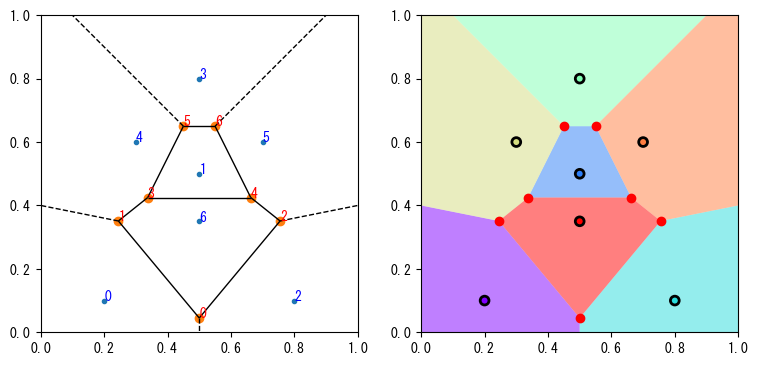

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))
ax1.set_aspect("equal")
ax2.set_aspect("equal")
spatial.voronoi_plot_2d(vo, ax=ax1)
for i, v in enumerate(vo.vertices):
    ax1.text(v[0], v[1], str(i), color="red")

for i, p in enumerate(points2d):
    ax1.text(p[0], p[1], str(i), color="blue")

n = len(points2d)
color = plt.cm.rainbow(np.linspace(0, 1, n))
for i in range(n):
    idx = vo2.point_region[i]
    region = vo2.regions[idx]
    poly = plt.Polygon(vo2.vertices[region], facecolor=color[i], alpha=0.5, zorder=0)
    ax2.add_artist(poly)
ax2.scatter(points2d[:, 0], points2d[:, 1], s=40, c=color, linewidths=2, edgecolors="k")
ax2.plot(vo2.vertices[:, 0], vo2.vertices[:, 1], "ro", ms=6)

for ax in ax1, ax2:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

ボロノイ図を使用して、最大空円問題を解決できます：一連の点の凸包領域内に中心があり、円内に点が存在しない最大半径の円を見つけることです。上のグラフによると、最大空円は必ず`vertices`を中心とし、最も近い母点までの距離を半径とする円のいずれかです。母点と`vertices`の間の関係を見つけるために、`Voronoi.point_region`を使用できます。`point_region[i]`は、`i`番目の母点（`points2d[i]`）に最も近い領域の番号です。例えば、以下の出力から、インデックス5の青い点はインデックス6の領域に対応し、`Voronoi.regions[6]`から、この領域はインデックス6、2、4の3つの`vertices`点（図中の赤い点）で構成されていることがわかります。したがって、`vertices`の中で母点`points2d[5]`に最も近い点のインデックスは`[2, 4, 6]`です。

In [33]:
print(vo.point_region)
print(vo.regions[6])

[0 3 1 7 4 6 5]
[6, -1, 2, 4]


以下は最大空円を計算するプログラムです。プログラムでは：❶`pylab.Polygon.contains_point()`を使用して、`ConvexHull`で計算された凸包多角形が`vertices`の点を含むかどうかを判断し、❷で凸包の外側にある円の中心を除外します。

❸`vertice_point_map`は辞書で、そのキーは`vertices`点のインデックスで、値はそれに最も近い`points2d`点のインデックスです。この辞書は`point_region`と`regions`を使用して構築され、凸包の外側にあるすべての`vertices`点が除外されます。

❹`vertice_point_map`内の各点のペアについて、最大距離のペアを見つけることで、円の中心座標と半径を求めることができます。

r =  0.17427845676199402 , center =  [0.46973363 0.59356531]


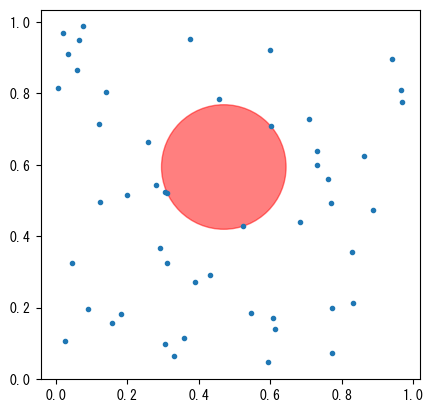

In [34]:
from collections import defaultdict

n = 50
np.random.seed(42)
points2d = np.random.rand(n, 2)
vo = spatial.Voronoi(points2d)
ch = spatial.ConvexHull(points2d)
poly = plt.Polygon(points2d[ch.vertices])  #❶
vs = vo.vertices
convexhull_mask = [poly.contains_point(p, radius=0) for p in vs]  #❷

vertice_point_map = defaultdict(list)  #❸
for index_point, index_region in enumerate(vo.point_region):
    region = vo.regions[index_region]
    if -1 in region:
        continue
    for index_vertice in region:
        if convexhull_mask[index_vertice]:
            vertice_point_map[index_vertice].append(index_point)


def dist(p1, p2):
    return ((p1 - p2) ** 2).sum() ** 0.5


max_cicle = max(
    (dist(points2d[pidxs[0]], vs[vidx]), vs[vidx])  #❹
    for vidx, pidxs in vertice_point_map.items()
)
r, center = max_cicle
print("r = ", r, ", center = ", center)

ax = plt.subplot(111, aspect="equal")
ax.plot(points2d[:, 0], points2d[:, 1], ".")

c = plt.Circle(center, r, fill=True, color="red", alpha=0.5)
ax.add_artist(c);

## ドロネー三角形分割

ドロネー三角形分割アルゴリズムは、与えられた点集合の凸包を三角形に分割し、各三角形の外接円が他の点を含まないようにします。以下のプログラムはドロネー三角形分割の効果を示しています。

`Delaunay`オブジェクト`dy`の`simplices`属性は、各三角形の頂点の`points2d`内のインデックスです。三角形の頂点座標から外接円の中心を計算できますが、ここでは同じ点集合のボロノイ図の`vertices`属性を使用します。`vertices`は各三角形の外接円の中心です。

In [35]:
x = np.array(
    [
        46.445,
        263.251,
        174.176,
        280.899,
        280.899,
        189.358,
        135.521,
        29.638,
        101.907,
        226.665,
    ]
)
y = np.array(
    [
        287.865,
        250.891,
        287.865,
        160.975,
        54.252,
        160.975,
        232.404,
        179.187,
        35.765,
        71.361,
    ]
)
points2d = np.c_[x, y]
dy = spatial.Delaunay(points2d)
vo = spatial.Voronoi(points2d)

%C dy.simplices; vo.vertices

dy.simplices           vo.vertices          
------------  ------------------------------
[[8, 5, 7],   [[104.58977484, 127.03566055],
 [1, 5, 3],    [235.1285    , 198.68143374],
 [5, 6, 7],    [107.83960707, 155.53682482],
 [6, 0, 7],    [ 71.22104881, 228.39479887],
 [0, 6, 2],    [110.3105    , 291.17642838],
 [6, 1, 2],    [201.40695449, 227.68436282],
 [1, 6, 5],    [201.61895891, 226.21958623],
 [9, 5, 8],    [152.96231864,  93.25060083],
 [4, 9, 8],    [205.40381294, -90.5480267 ],
 [5, 9, 3],    [235.1285    , 127.45701644],
 [9, 4, 3]]    [267.91709907, 107.6135    ]]


以下は`delaunay_plot_2d()`を使用してドロネー三角形分割の結果を描画したものです。また、各外接円とその中心も描画しています。三角形のすべての頂点がどの外接円の内側にもないことがわかります：

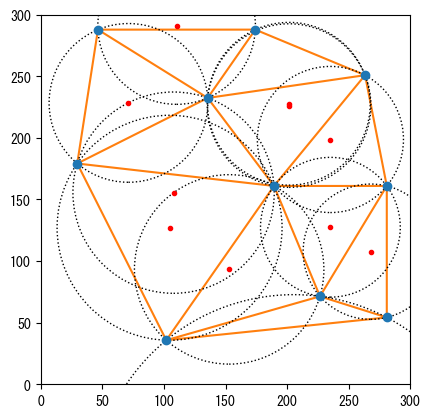

In [36]:
cx, cy = vo.vertices.T

ax = plt.subplot(aspect="equal")
spatial.delaunay_plot_2d(dy, ax=ax)
ax.plot(cx, cy, "r.")
for i, (cx, cy) in enumerate(vo.vertices):
    px, py = points2d[dy.simplices[i, 0]]
    radius = np.hypot(cx - px, cy - py)
    circle = plt.Circle((cx, cy), radius, fill=False, ls="dotted")
    ax.add_artist(circle)
ax.set_xlim(0, 300)
ax.set_ylim(0, 300);